<a href="https://colab.research.google.com/github/vbaryshev/Overpass_API/blob/main/Mamisin_classifikator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## Настройка загрузчиков данных


Мы будем использовать встроенный набор данных`torchvision.datasets.ImageFolder` чтобы быстро настроить некоторые загрузчики данных загруженных изображений кошек и рыб. 

`check_image` — это небольшая быстрая функция, которая передается параметру is_valid_file в ImageFolder и выполняет проверку работоспособности, чтобы убедиться, что PIL действительно может открыть файл. Мы собираемся использовать это вместо очистки загруженного набора данных.


In [ ]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

Настройте преобразования для каждого изображения:

* Изменение размера до 64x64
* Преобразовать в тензор
* Нормализация с использованием среднего и стандартного значений ImageNet


In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)), # transforms.Resize((64,64)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])



In [ ]:
train_data_path = "/home/geonode/data/train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

In [ ]:
val_data_path = "/home/geonode/data/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [ ]:
test_data_path = "/home/geonode/data/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, is_valid_file=check_image) 

In [ ]:
batch_size=64 #batch_size=64

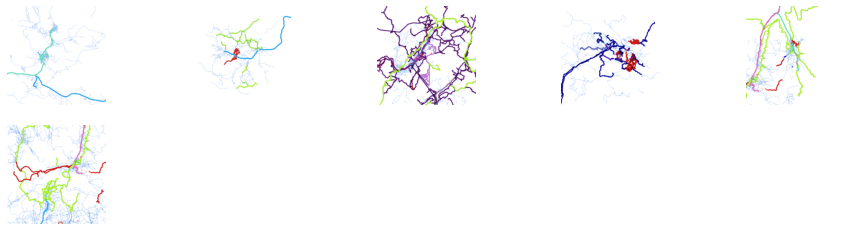

In [ ]:
# импортируем библиотеки
import os
import matplotlib.pyplot as plt
import cv2
 
# получим список с именами всех картинок, находящихся в папке pic
pictures = os.listdir('/home/geonode/data/train/good/')
# Упорядочим список 
pictures = sorted(pictures)
# Создадим фигуру размером 16 на 4 дюйма
pic_box = plt.figure(figsize=(16,4))
 
# Поочередно считываем в переменную picture имя изображения из списка pictures. В переменную i записываем номер итерации
for i, picture in enumerate(pictures):
    # считываем изображение в picture
    picture = cv2.imread('/home/geonode/data/train/good/' + picture)
    # конвертируем BGR изображение в RGB
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    # добавляем ячейку в pix_box для вывода текущего изображения
    pic_box.add_subplot(2,5,i+1)
    plt.imshow(picture)
    # отключаем отображение осей
    plt.axis('off')
# выводим все созданные фигуры на экран
plt.show()

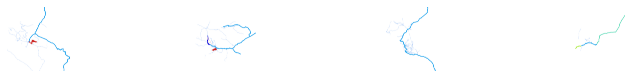

In [ ]:
# получим список с именами всех картинок, находящихся в папке pic
pictures = os.listdir('/home/geonode/data/train/bad/')
# Упорядочим список 
pictures = sorted(pictures)
# Создадим фигуру размером 16 на 4 дюйма
pic_box = plt.figure(figsize=(16,4))
 
# Поочередно считываем в переменную picture имя изображения из списка pictures. В переменную i записываем номер итерации
for i, picture in enumerate(pictures):
    # считываем изображение в picture
    picture = cv2.imread('/home/geonode/data/train/bad/' + picture)
    # конвертируем BGR изображение в RGB
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    # добавляем ячейку в pix_box для вывода текущего изображения
    pic_box.add_subplot(3,5,i+1)
    plt.imshow(picture)
    # отключаем отображение осей
    plt.axis('off')
# выводим все созданные фигуры на экран
plt.show()

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

## Модель

SimpleNet — это очень простая комбинация трех линейных слоев и активаций ReLu между ними. Обратите внимание, что, поскольку мы не делаем `softmax()` в нашем `forward()`, нам нужно убедиться, что мы делаем это в нашей обучающей функции на этапе проверки.

In [ ]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        #self.fc1 = nn.Linear(5095857, 84)
        self.fc1 = nn.Linear(12288, 84) 
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        #x = x.view(-1, 5095857)
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
simplenet = SimpleNet()

## оптимизатор

со скоростью обучения 0,001.

In [ ]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

## Скопировать модель в GPU

Скопируйте модель в GPU, если она доступна.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Обучение

Обучает модель, при необходимости копируя пакеты на GPU, вычисляя потери, оптимизируя сеть и выполняя проверку для каждой эпохи.

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [ ]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)

Epoch: 1, Training Loss: 0.68, Validation Loss: 0.05, accuracy = 1.00
Epoch: 2, Training Loss: 1.70, Validation Loss: 9.75, accuracy = 0.00
Epoch: 3, Training Loss: 4.05, Validation Loss: 10.17, accuracy = 0.00
Epoch: 4, Training Loss: 4.19, Validation Loss: 6.86, accuracy = 0.00
Epoch: 5, Training Loss: 2.85, Validation Loss: 2.71, accuracy = 0.00


## Делать прогнозы

Метки расположены в алфавитно-цифровом порядке, поэтому «кошка» будет равна 0, «рыба» будет равна 1. Нам нужно преобразовать изображение, а также убедиться, что полученный тензор скопирован на соответствующее устройство, прежде чем применять к нему нашу модель.

good


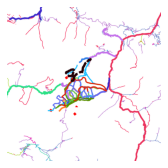

In [ ]:
labels = ['bad','good']

img = Image.open("/home/geonode/data/val/test/Mamison.png")
img = img.convert('RGB')
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval()
prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

# получим список с именами всех картинок, находящихся в папке pic
pictures = os.listdir('/home/geonode/data/val/test/')
# Упорядочим список 
pictures = sorted(pictures)
# Создадим фигуру размером 16 на 4 дюйма
pic_box = plt.figure(figsize=(16,16))
 
# Поочередно считываем в переменную picture имя изображения из списка pictures. В переменную i записываем номер итерации
for i, picture in enumerate(pictures):
    # считываем изображение в picture
    picture = cv2.imread('/home/geonode/data/val/test/' + picture)
    # конвертируем BGR изображение в RGB
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    # добавляем ячейку в pix_box для вывода текущего изображения
    pic_box.add_subplot(3,5,i+1)
    plt.imshow(picture)
    # отключаем отображение осей
    plt.axis('off')
# выводим все созданные фигуры на экран
plt.show()

## Сохранение модели

We can either save the entire model using `save` or just the parameters using `state_dict`. Using the latter is normally preferable, as it allows you to reuse parameters even if the model's structure changes (or apply parameters from one model to another).

In [ ]:
print (Image.open("/home/geonode/data/image_test/images.jpeg"))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=203x249 at 0x7FB65BE5EAC0>


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
img_test=Image.open("/home/geonode/data/image_test/images.jpeg")

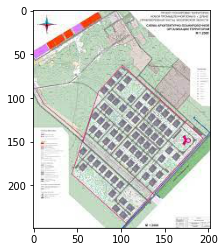

In [ ]:
plt.imshow(img_test)
plt.show()

In [ ]:
torch.save(simplenet, "/tmp/simplenet") 
simplenet = torch.load("/tmp/simplenet")    


In [ ]:
torch.save(simplenet.state_dict(), "/tmp/simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("/tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)   